Este projeto visa realizar uma modelagem estatística de um problema de regressão para dados salariais de profissionais na área de dados.

* Biblioteca

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

* Carregando os dados

Os dados foram obtidos no site Kaggle, uma plataforma voltada a ciência de dados.
link: https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

In [38]:
df = pd.read_csv('ds_salaries.csv')
df.head()

,id,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


* Entendimento dos dados

Os dados contém informações gerais sobre porfissionais da área de dados. Temos como objetivo a modelagem estatística de uma regressão com a biblioteca *statsmodels* para prever o salário (salary_in_usd) com base nas informações do dataset.

In [39]:
# Definindo uma função para criar os metadados de um dataframe

def metadados(df):
    ''' Cria uma tabela com informações do dataframe'''

    meta = pd.DataFrame({'dtypes': df.dtypes})
    meta['nunique'] = df.nunique()
    meta['missing'] = df.isnull().sum()
    
    return meta

metadados(df)

,dtypes,nunique,missing
id,int64,607,0
work_year,int64,3,0
experience_level,object,4,0
employment_type,object,4,0
job_title,object,50,0
salary,int64,272,0
salary_currency,object,17,0
salary_in_usd,int64,369,0
employee_residence,object,57,0
remote_ratio,int64,3,0


In [40]:
print(f'Número de linhas: {df.shape[0]}\nNúmero de colunas: {df.shape[1]}')

Número de linhas: 607
Número de colunas: 12


In [41]:
# Visualizando a separação de dados em categóricos e numéricos:

df_categorica = df.select_dtypes('object')
df_numerica = df.select_dtypes(exclude='object').drop(columns=['id'])

list_cat = list(df_categorica.columns)
list_num = list(df_numerica.columns)

print(f'Número de colunas com variáveis categóricas: {df_categorica.shape[1]}.\n  Lista:\n {list_cat}')
print('\n\n')
print(f'Número de colunas com variáveis numericas: {df_numerica.shape[1]}.\n  Lista:\n {list_num}')

Número de colunas com variáveis categóricas: 7.
  Lista:
 ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']



Número de colunas com variáveis numericas: 4.
  Lista:
 ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']


In [42]:
# Estatísticas das variáveis categóricas:

df_categorica.describe().transpose()

,count,unique,top,freq
experience_level,607,4,SE,280
employment_type,607,4,FT,588
job_title,607,50,Data Scientist,143
salary_currency,607,17,USD,398
employee_residence,607,57,US,332
company_location,607,50,US,355
company_size,607,3,M,326


In [43]:
# Estatísticas das variáveis numéricas:

df_numerica.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
work_year,607.0,2021.405272,6.921330e-01,2020.0,2021.0,2022.0,2022.0,2022.0
salary,607.0,324000.062603,1.544357e+06,4000.0,70000.0,115000.0,165000.0,30400000.0
salary_in_usd,607.0,112297.869852,7.095726e+04,2859.0,62726.0,101570.0,150000.0,600000.0
remote_ratio,607.0,70.922570,4.070913e+01,0.0,50.0,100.0,100.0,100.0


* Análise Univariada

Nesta sessão realizamos uma análise das variáveis:

In [44]:
# Definindo uma função para gerar um gráfico de barras de uma variável categórica:

def graf_bar(df, var):
    """ Recebe um dataframe e uma string de variável categórica e retorna
    um barplot
    """
    g = df[var].value_counts().sort_values()

    plt.figure(figsize=(12,8))
    sns.barplot(x=g.index, y=g)
    plt.title(f'Distribuição de {var}')
    plt.ylabel('Contagem')
    plt.xticks(rotation=60)

Variáveis categoricas:

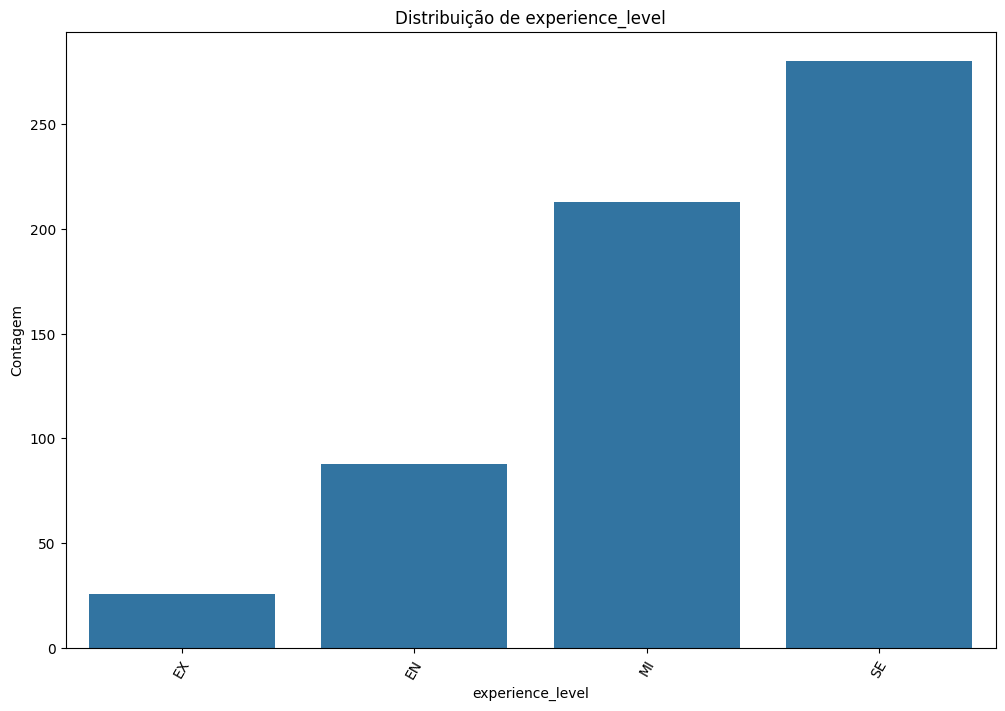

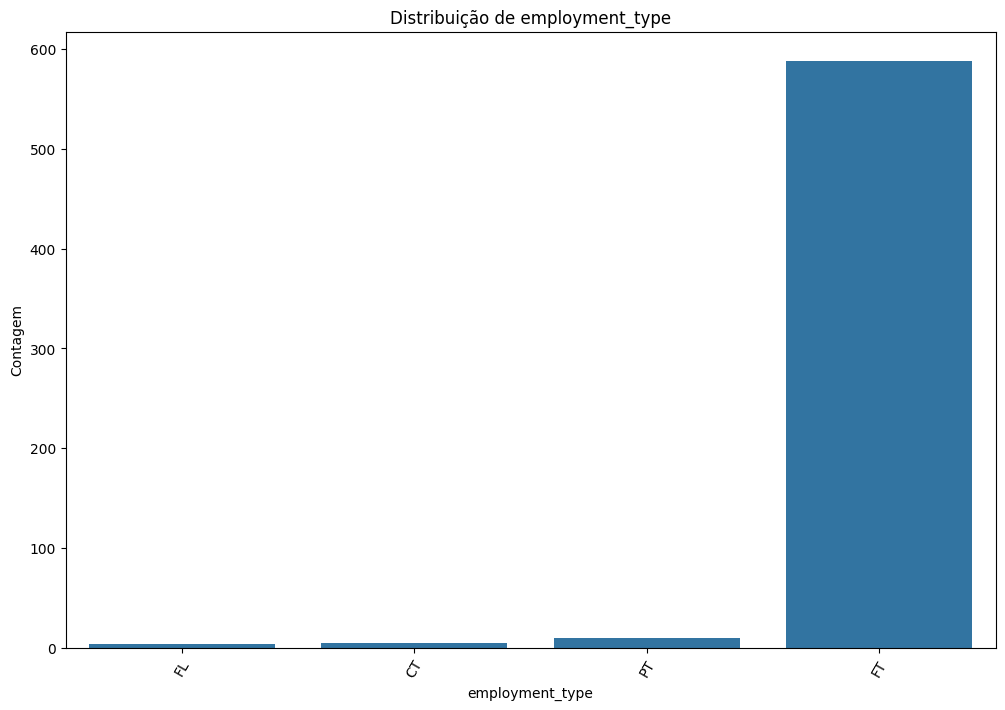

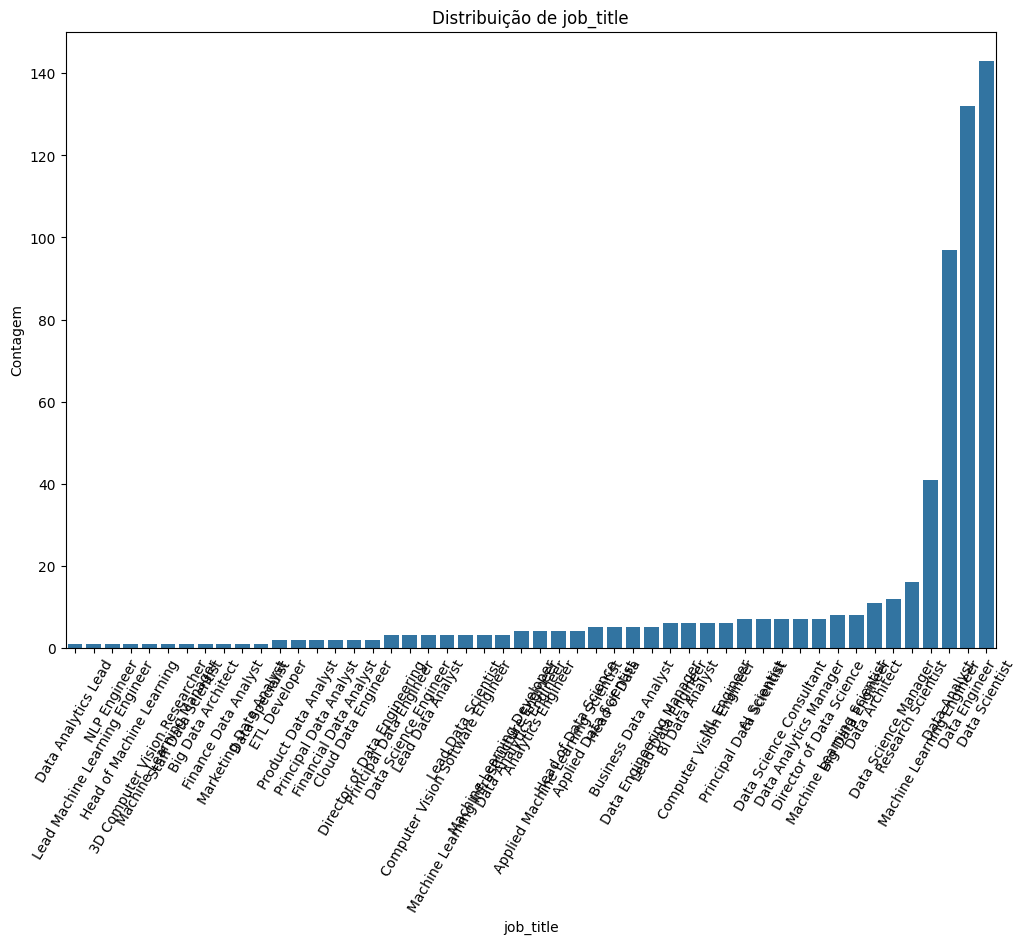

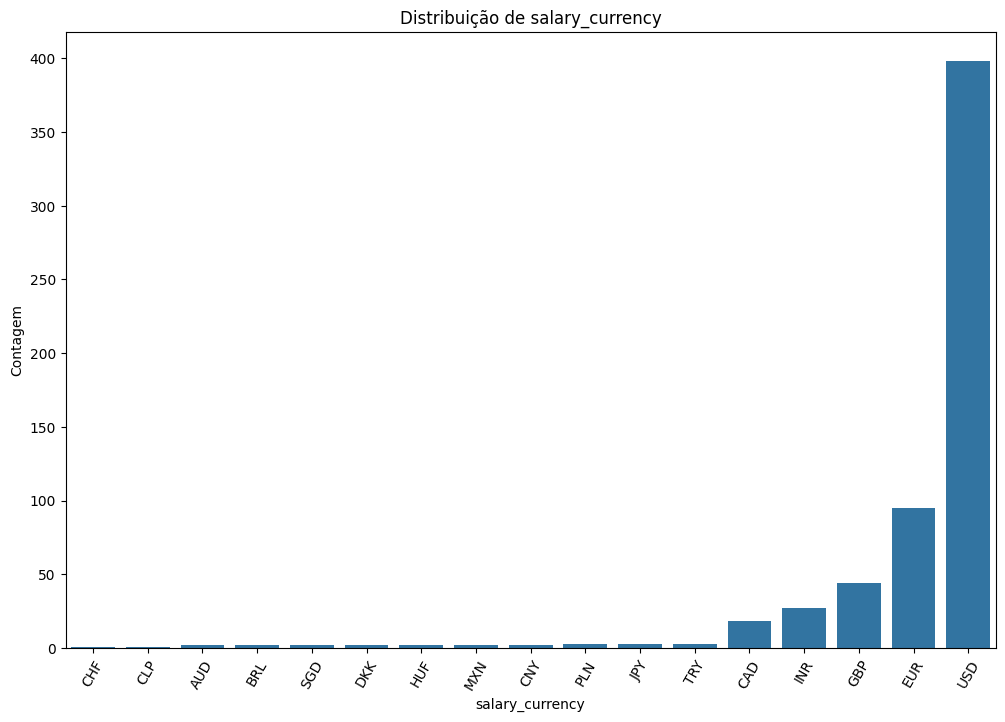

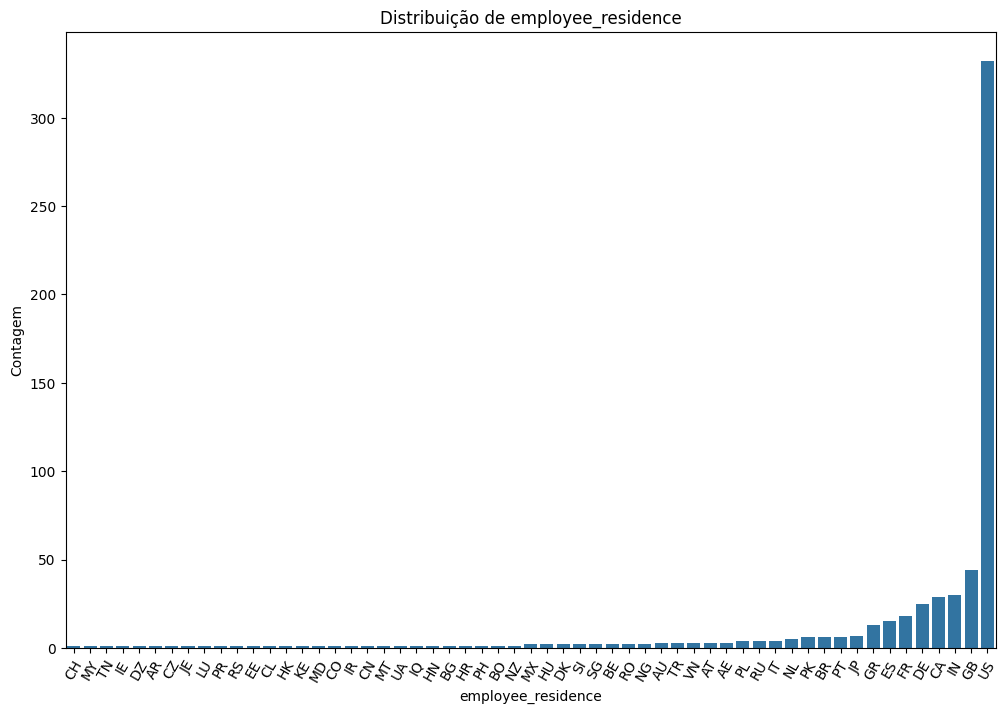

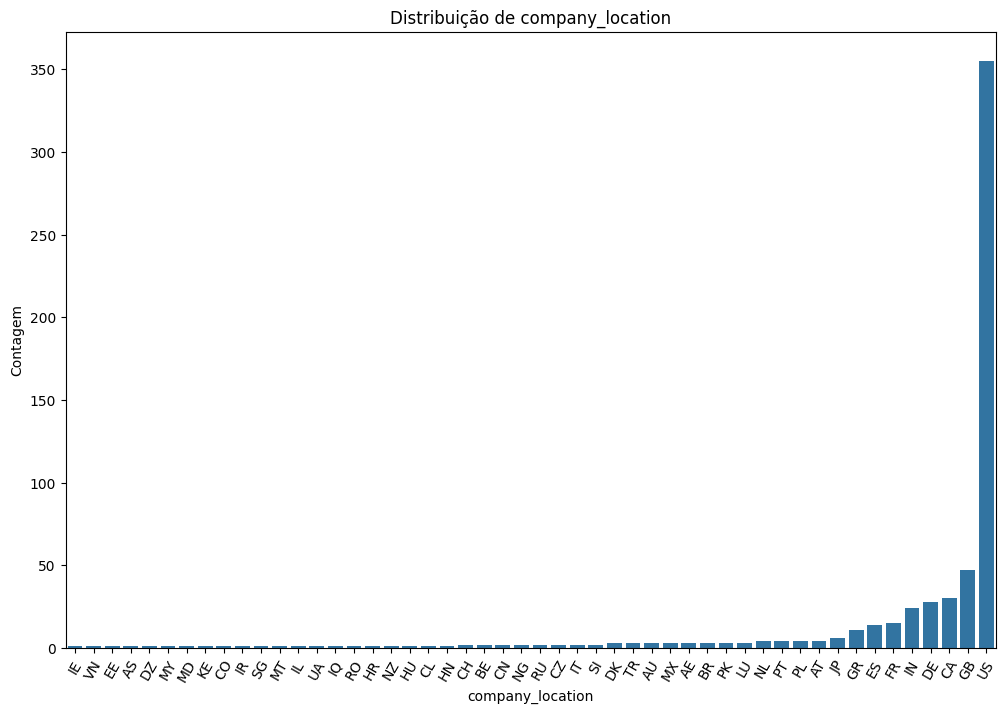

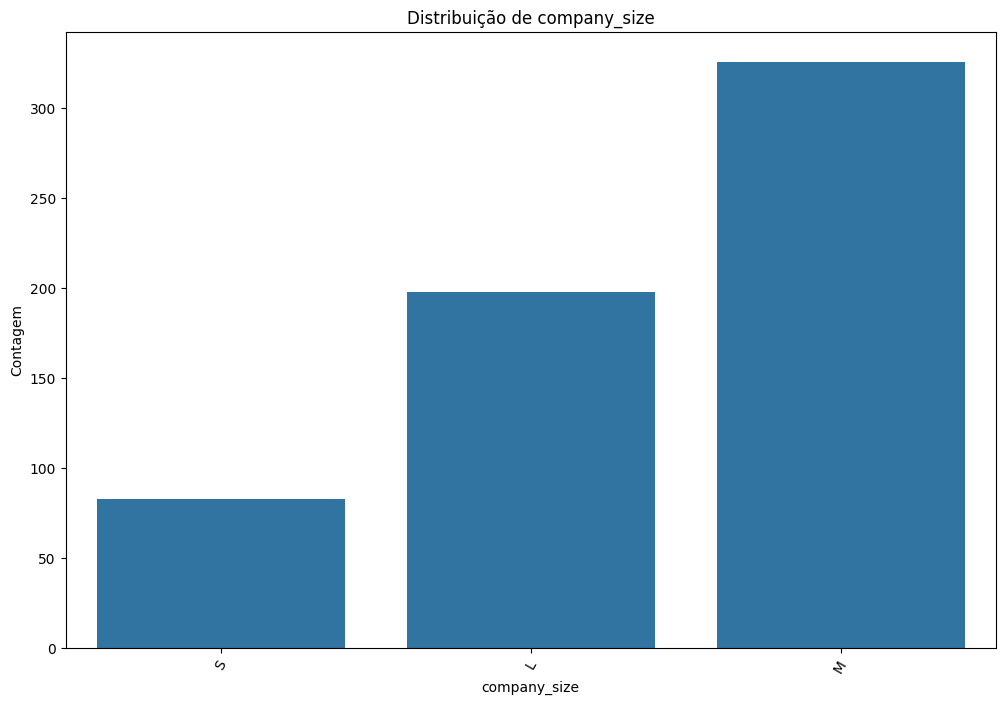

In [45]:
for var in list_cat:
    graf_bar(df, var)

Acima podemos observar a distribuição de cada variável categórica do dataset.

'employee_residence' e 'company_location' tem muitas entradas para a classe 'US' e baixíssimas entradas para as demais classes. Para otimizar nossa análise, iremos agrupar estas classes em 'US' e 'Not US'.

'employment_type' é outra variável fortemente desbalanceada. Mais adiante iremos analisar sua relação com a variável alvo para determinar um tratamente adequado.

A variável 'job_title' apresenta alta cardinalidade, isto é, diversas entradas únicas, referentes a diversos tipos de títulos a empregos na área de dados, podemos agrupar diversos títulos em algumas classes mais representativas.

In [46]:
# Criando uma cópia do dataframe, na qual será armazenada as transformações feitas:

df2 = df.copy()

# Agrupando as classes de 'company_location' e 'employee_residence'

df2['employee_residence'] = df['employee_residence'].apply(lambda x: 'US' if x == 'US' else 'Not_US')
df2['company_location'] = df['company_location'].apply(lambda x: 'US' if x == 'US' else 'Not_US')

In [47]:
# Verificando a variável 'job_title':

df['job_title'].value_counts()

job_title
Data Scientist                              143
Data Engineer                               132
Data Analyst                                 97
Machine Learning Engineer                    41
Research Scientist                           16
Data Science Manager                         12
Data Architect                               11
Big Data Engineer                             8
Machine Learning Scientist                    8
Principal Data Scientist                      7
AI Scientist                                  7
Data Science Consultant                       7
Director of Data Science                      7
Data Analytics Manager                        7
ML Engineer                                   6
Computer Vision Engineer                      6
BI Data Analyst                               6
Lead Data Engineer                            6
Data Engineering Manager                      5
Business Data Analyst                         5
Head of Data                  

In [48]:
# Vamos agrupar todos estes títulos em poucas classes, mantendo a representatividade:

mapeamento = {
    'Data Scientist': 'Data Scientist',
    'Data Engineer': 'Data Engineer',
    'Data Analyst': 'Data Analyst',
    'Machine Learning Engineer': 'Machine Learning',
    'Research Scientist': 'Scientist',
    'Data Science Manager': 'Manager',
    'Data Architect': 'Architect',
    'Big Data Engineer': 'Data Engineer',
    'Machine Learning Scientist': 'Machine Learning',
    'Principal Data Scientist': 'Data Scientist',
    'AI Scientist': 'Scientist',
    'Data Science Consultant': 'Consultant',
    'Director of Data Science': 'Director',
    'Data Analytics Manager': 'Manager',
    'ML Engineer': 'Machine Learning',
    'Computer Vision Engineer': 'Computer Vision',
    'BI Data Analyst': 'Data Analyst',
    'Lead Data Engineer': 'Data Engineer',
    'Data Engineering Manager': 'Manager',
    'Business Data Analyst': 'Data Analyst',
    'Head of Data': 'Head',
    'Applied Data Scientist': 'Data Scientist',
    'Applied Machine Learning Scientist': 'Machine Learning',
    'Head of Data Science': 'Head',
    'Analytics Engineer': 'Analytics',
    'Data Analytics Engineer': 'Analytics',
    'Machine Learning Developer': 'Machine Learning',
    'Machine Learning Infrastructure Engineer': 'Machine Learning',
    'Lead Data Scientist': 'Data Scientist',
    'Computer Vision Software Engineer': 'Computer Vision',
    'Lead Data Analyst': 'Data Analyst',
    'Data Science Engineer': 'Data Engineer',
    'Principal Data Engineer': 'Data Engineer',
    'Principal Data Analyst': 'Data Analyst',
    'ETL Developer': 'Outros',
    'Product Data Analyst': 'Data Analyst',
    'Director of Data Engineering': 'Director',
    'Financial Data Analyst': 'Data Analyst',
    'Cloud Data Engineer': 'Data Engineer',
    'Lead Machine Learning Engineer': 'Machine Learning',
    'NLP Engineer': 'Outro',
    'Head of Machine Learning': 'Head',
    '3D Computer Vision Researcher': 'Computer Vision',
    'Data Specialist': 'Outros',
    'Staff Data Scientist': 'Data Scientist',
    'Big Data Architect': 'Architect',
    'Finance Data Analyst': 'Data Analyst',
    'Marketing Data Analyst': 'Data Analyst',
    'Machine Learning Manager': 'Manager',
    'Data Analytics Lead': 'Analytics'
}

df2['job_title'] = df['job_title'].map(mapeamento)

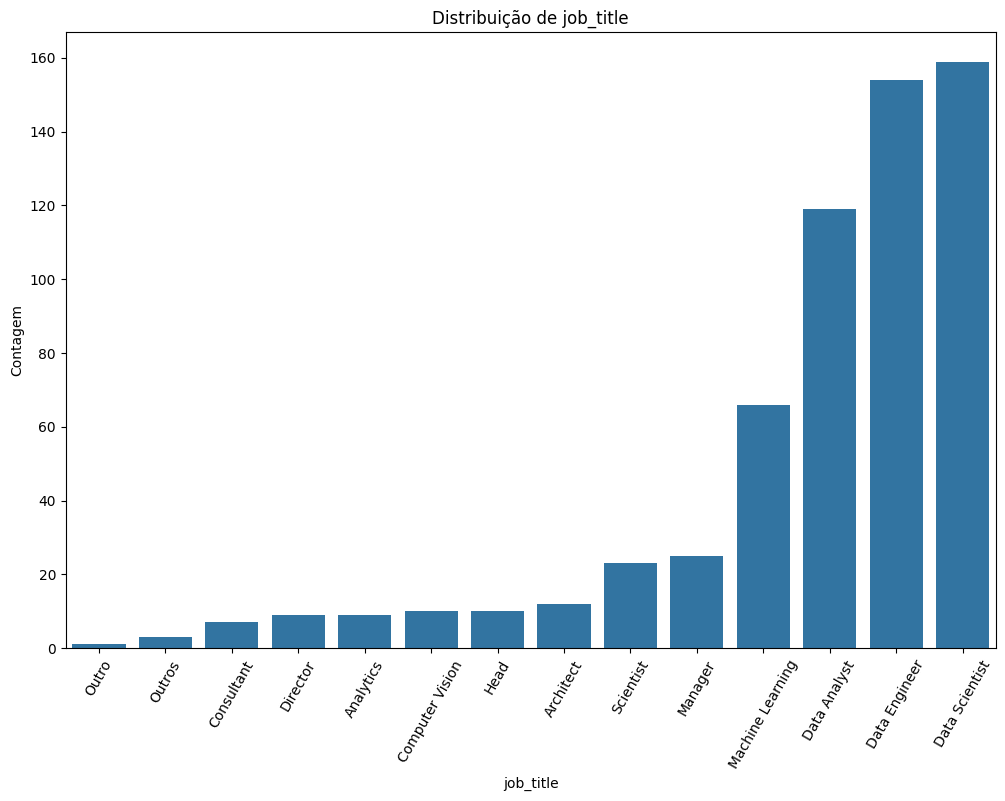

In [49]:
# Visualizando a distribuição de 'job_title' após o agrupamento:

graf_bar(df2, 'job_title')

Variáveis numéricas:

Das variáveis classificadas como numéricas, duas delas podem ser classificadas como categóricas:

In [50]:
df['remote_ratio'].unique()

array([  0,  50, 100], dtype=int64)

In [51]:
df['work_year'].unique()

array([2020, 2021, 2022], dtype=int64)

In [52]:
# Categorizando as variáveis:

df2['remote_ratio'] = df['remote_ratio'].astype(str)
df2['work_year'] = df['work_year'].astype(str)

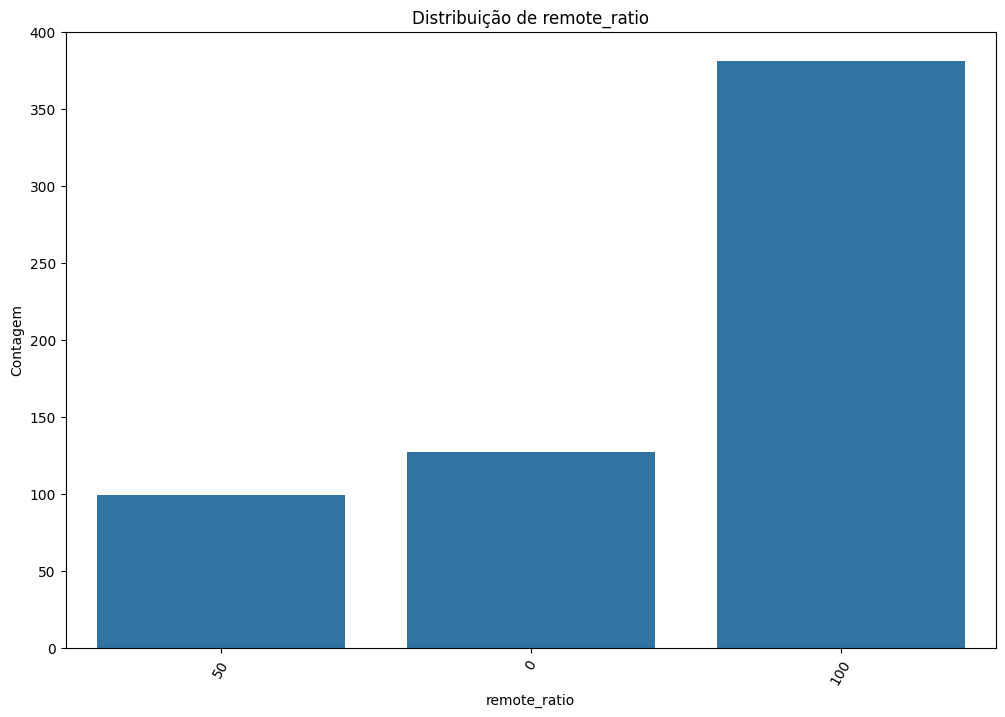

In [53]:
graf_bar(df2, 'remote_ratio')

Maior parte das entradas são de trabalhos remotos.

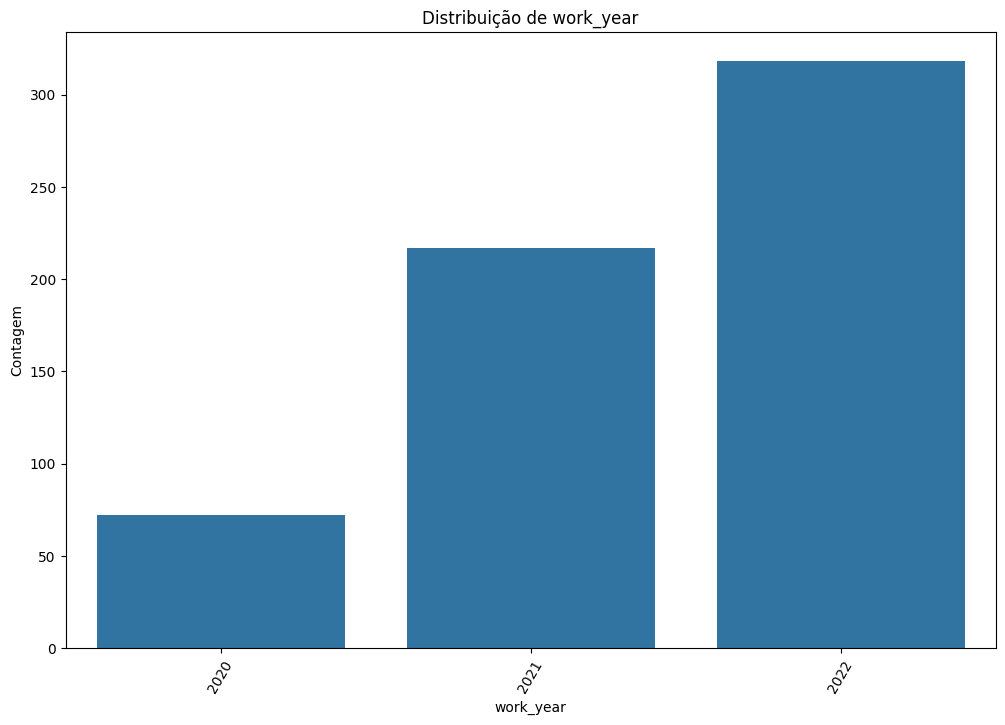

In [54]:
graf_bar(df2, 'work_year')

Não faz sentido analisar a distribuição da variável 'salary', visto que diversas entradas contém unidades diferentes. Considerando isso e que nossa variável alvo é 'salary_in_usd'. Excluiremos esta variiável da nossa análise.

Text(0, 0.5, 'Contagem')

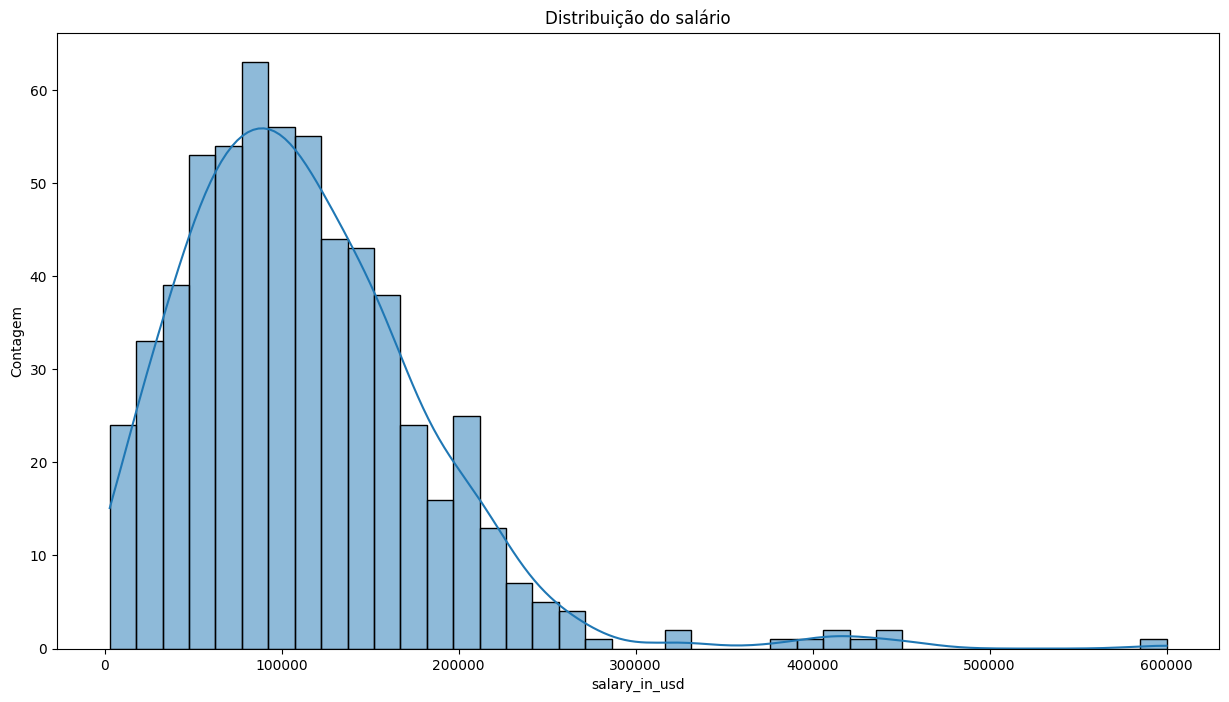

In [55]:
plt.figure(figsize=(15,8))
sns.histplot(data=df, x='salary_in_usd', bins=40, kde=True)
plt.title('Distribuição do salário')
plt.ylabel('Contagem')

Podemos notar alguns valores distântes da média. Para melhor entender a distribuição da variável alvo, podemos usar um boxplot:

Text(0.5, 1.0, 'Boxplot do salário')

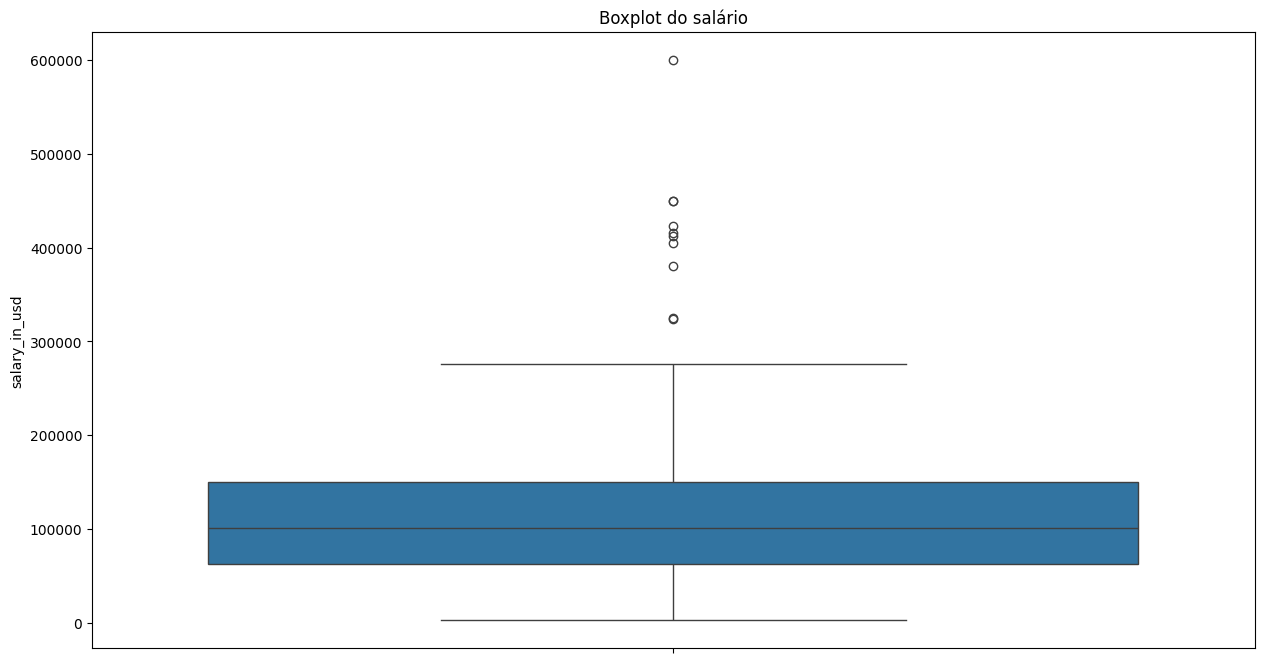

In [56]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df, y='salary_in_usd')
plt.title('Boxplot do salário')

Podemos identificar diversos pontos acima do limite superior, indicando a presença de outliers que podem afetar negativamente o modelo de regressão.

* Análise Bivariada

Nesta sessão analisamos a relação entre as variáveis com a variável alvo:

In [57]:
def graf_point(df, var):
    ''' Gera um poitplot ordenado de uma variável numérica em relação a categoria'''
    
    sns.pointplot(data=df, x=var, y='salary_in_usd')
    plt.title(f'Pointplot do salário em relação a {var}')
    plt.xticks(rotation=45)
    plt.ylabel('Salário')

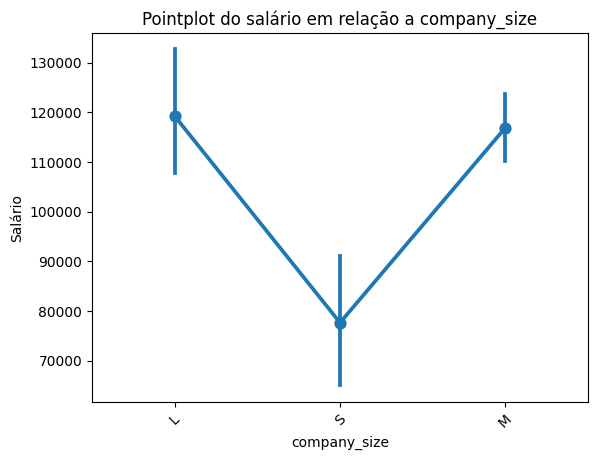

In [58]:
graf_point(df2, 'company_size')

Com o poitplot podemos analisar se as classes de uma variável é estatisticamente relevante para discriminar o alvo. 

Na variável 'company_size' podemos notar que as classes 'M' e 'L' tem intercesão nos seus intervalos, indicando que as duas classes não discriminam bem a variável alvo.

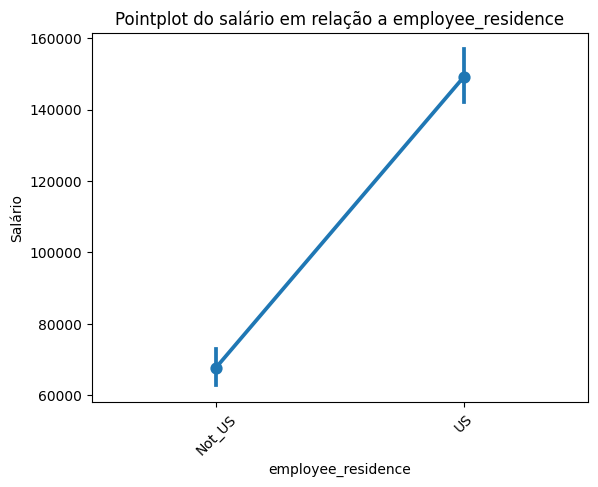

In [59]:
graf_point(df2, 'employee_residence')

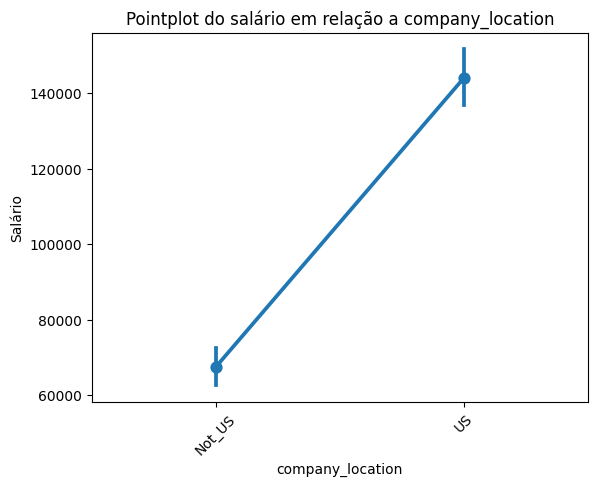

In [60]:
graf_point(df2, 'company_location')

'company_location' e 'employee_residence', no agrupamento feito anteriormente, é estatisticamente relevante para discriminar a variável alvo.

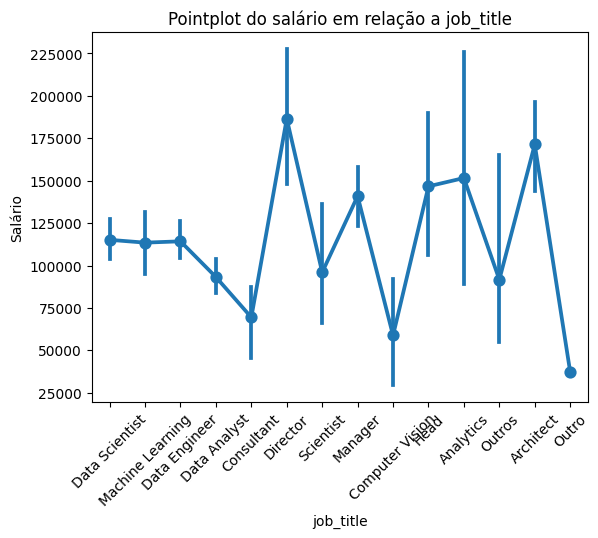

In [61]:
graf_point(df2, 'job_title')

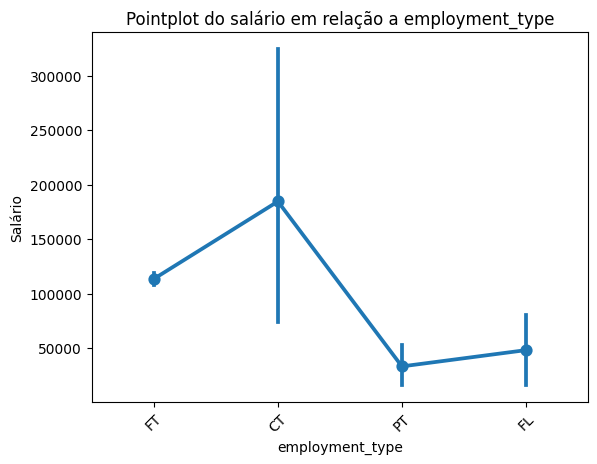

In [62]:
graf_point(df2, 'employment_type')

Agora que temos informações de 'employment_type' em relação ao salário, podemos fazer um agrupamento mais relavante.

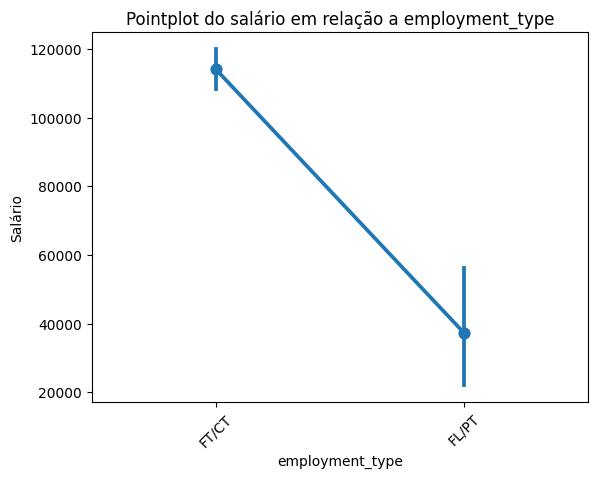

In [63]:
df2['employment_type'].replace({
    'FT': 'FT/CT',
    'CT': 'FT/CT',
    'FL': 'FL/PT',
    'PT': 'FL/PT'
}, inplace=True)

graf_point(df2, 'employment_type')

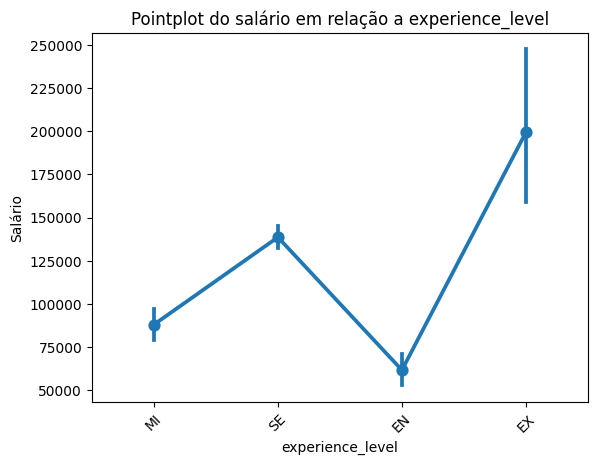

In [64]:
graf_point(df2, 'experience_level')

* Modelagem

In [65]:
' + '.join(list(df.columns))

'id + work_year + experience_level + employment_type + job_title + salary + salary_currency + salary_in_usd + employee_residence + remote_ratio + company_location + company_size'

In [66]:
# Modelo inicial:

formula = '''salary_in_usd ~ C(work_year) + C(experience_level) + C(employment_type)
     + C(employee_residence) + C(remote_ratio) + C(salary_currency)
    + C(company_location) + C(company_size) + C(job_title)'''

reg = smf.ols(formula, data=df2).fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          salary_in_usd   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     16.14
Date:                Tue, 07 May 2024   Prob (F-statistic):           1.08e-70
Time:                        21:25:52   Log-Likelihood:                -7405.6
No. Observations:                 607   AIC:                         1.490e+04
Df Residuals:                     565   BIC:                         1.508e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         7.068e+04   4.33e+04      1.631      0.103   -1.44e+04    1.56e+05
C(work_year)[T.2021]             -9516.2943   7060.491     -1.348      0.178   -2.34e+04    4351.722
C(work_year)[T.2022]             -1.194e+04   7835.089     -1.524      0.128   -2.73e+04    3450.144
C(experience_level)[T.EX]         1.165e+05   1.35e+04      8.655      0.000    9.01e+04    1.43e+05
C(experience_level)[T.MI]         2.265e+04   6877.531      3.293      0.001    9138.151    3.62e+04
C(experience_level)[T.SE]         4.681e+04   7076.389      6.615      0.000    3.29e+04    6.07e+04
C(employment_type)[T.FT/CT]       1.918e+04   1.48e+04      1.296      0.196   -9900.460    4.83e+04
C(employee_residence)[T.US]       5.928e+04   1.12e+04      5.274      0.000    3.72e+04    8.14e+04
C(remote_ratio)[T.100]            4075.9115   5440.756      0.749      0.454   -6610.667    1.48e+04
C(remote_ratio)[T.50]            -4568.3184   7754.237     -0.589      0.556   -1.98e+04    1.07e+04
C(salary_currency)[T.BRL]        -7.887e+04   5.18e+04     -1.524      0.128   -1.81e+05    2.28e+04
C(salary_currency)[T.CAD]        -1.841e+04   3.77e+04     -0.488      0.625   -9.24e+04    5.56e+04
C(salary_currency)[T.CHF]         2.247e+04   6.16e+04      0.365      0.715   -9.85e+04    1.43e+05
C(salary_currency)[T.CLP]        -6.633e+04   6.17e+04     -1.075      0.283   -1.88e+05    5.48e+04
C(salary_currency)[T.CNY]          -6.6e+04   6.24e+04     -1.059      0.290   -1.88e+05    5.65e+04
C(salary_currency)[T.DKK]        -1.776e+04   5.21e+04     -0.341      0.733    -1.2e+05    8.45e+04
C(salary_currency)[T.EUR]         -2.95e+04   3.61e+04     -0.817      0.414      -1e+05    4.14e+04
C(salary_currency)[T.GBP]        -3003.9810   3.65e+04     -0.082      0.934   -7.48e+04    6.88e+04
C(salary_currency)[T.HUF]        -5.021e+04   5.08e+04     -0.989      0.323    -1.5e+05    4.95e+04
C(salary_currency)[T.INR]        -6.025e+04   3.71e+04     -1.625      0.105   -1.33e+05    1.26e+04
C(salary_currency)[T.JPY]        -2.191e+04   4.63e+04     -0.473      0.637   -1.13e+05    6.91e+04
C(salary_currency)[T.MXN]        -7.741e+04   5.13e+04     -1.508      0.132   -1.78e+05    2.34e+04
C(salary_currency)[T.PLN]        -6.996e+04    4.6e+04     -1.520      0.129    -1.6e+05    2.05e+04
C(salary_currency)[T.SGD]         1.437e+04   5.05e+04      0.285      0.776   -8.48e+04    1.14e+05
C(salary_currency)[T.TRY]        -7.376e+04   4.64e+04     -1.590      0.112   -1.65e+05    1.74e+04
C(salary_currency)[T.USD]        -1.329e+04   3.65e+04     -0.364      0.716   -8.49e+04    5.84e+04
C(company_location)[T.US]         2352.6806   1.15e+04      0.205      0.837   -2.02e+04    2.49e+04
C(company_size)[T.M]             -1.542e+04   5572.12

Podemos identificar algumas variáveis com pouco poder de predição para nosso alvo, indicadas por alto valor de P-value, além disso, o valor dos coeficientes são muito altos, o que dificulta a interpretação dos parâmetros do modelo, isto pode ser associado a dois problemas:

- Presença majoritária de variáveis categóricas
- Variável alvo é monetária, geralmente variáveis deste tipo tem um crescimento muito acentuado. Podemos contornar este problema prevendo o logarítmo do salário.

In [67]:
# Novo modelo:

formula2 = '''np.log(salary_in_usd) ~ C(work_year) + C(experience_level) + C(employment_type)
     + C(employee_residence) + C(salary_currency)
    + C(company_location) + C(company_size) + C(job_title)'''


reg2 = smf.ols(formula2, data=df2).fit()

reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(salary_in_usd)   R-squared:                       0.678
Model:                               OLS   Adj. R-squared:                  0.656
Method:                    Least Squares   F-statistic:                     30.57
Date:                   Tue, 07 May 2024   Prob (F-statistic):          4.77e-114
Time:                           21:25:52   Log-Likelihood:                -361.76
No. Observations:                    607   AIC:                             803.5
Df Residuals:                        567   BIC:                             979.9
Df Model:                             39                                         
Covariance Type:               nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           10.5398      0.390     27.038      0.000       9.774      11.305
C(work_year)[T.2021]                -0.0690      0.064     -1.074      0.283      -0.195       0.057
C(work_year)[T.2022]                 0.0086      0.071      0.122      0.903      -0.130       0.148
C(experience_level)[T.EX]            0.9226      0.122      7.538      0.000       0.682       1.163
C(experience_level)[T.MI]            0.2742      0.063      4.386      0.000       0.151       0.397
C(experience_level)[T.SE]            0.5744      0.064      8.912      0.000       0.448       0.701
C(employment_type)[T.FT/CT]          0.6311      0.134      4.706      0.000       0.368       0.895
C(employee_residence)[T.US]          0.6106      0.102      5.970      0.000       0.410       0.811
C(salary_currency)[T.BRL]           -1.7504      0.468     -3.739      0.000      -2.670      -0.831
C(salary_currency)[T.CAD]           -0.2161      0.343     -0.630      0.529      -0.890       0.458
C(salary_currency)[T.CHF]            0.1698      0.559      0.304      0.761      -0.928       1.268
C(salary_currency)[T.CLP]           -0.8696      0.561     -1.551      0.121      -1.971       0.231
C(salary_currency)[T.CNY]           -0.7929      0.565     -1.403      0.161      -1.903       0.317
C(salary_currency)[T.DKK]           -0.2352      0.474     -0.496      0.620      -1.166       0.696
C(salary_currency)[T.EUR]           -0.4205      0.329     -1.280      0.201      -1.066       0.225
C(salary_currency)[T.GBP]           -0.1258      0.332     -0.379      0.705      -0.778       0.526
C(salary_currency)[T.HUF]           -0.9557      0.462     -2.070      0.039      -1.863      -0.049
C(salary_currency)[T.INR]           -1.4245      0.337     -4.227      0.000      -2.086      -0.763
C(salary_currency)[T.JPY]           -0.2711      0.422     -0.642      0.521      -1.100       0.558
C(salary_currency)[T.MXN]           -2.2459      0.464     -4.838      0.000      -3.158      -1.334
C(salary_currency)[T.PLN]           -1.0073      0.418     -2.412      0.016      -1.828      -0.187
C(salary_currency)[T.SGD]            0.1908      0.460      0.415      0.678      -0.713       1.094
C(salary_currency)[T.TRY]           -1.5634      0.422     -3.705      0.000      -2.392      -0.734
C(salary_currency)[T.USD]           -0.5029      0.332     -1.517      0.130      -1.154       0.148
C(company_location)[T.US]            0.1911      0.104      1.845      0.066      -0.012       0.395
C(company_size)[T.M]                -0.1622      0.050     -3.219      0.001      -0.261      -0.063
C(company_size)[T.S]                -0.1836      0.066     -2.785      0.006      -0.313      -0.054
C(job_title)[T.Archi

Após a transformação na variável alvo podemos notar que os coeficientes das variáveis explicativas foram reduzidos, melhorando a capacidade de interpretação do modelo.

* Análise de Resíduos

<Axes: xlabel='company_size', ylabel='res'>

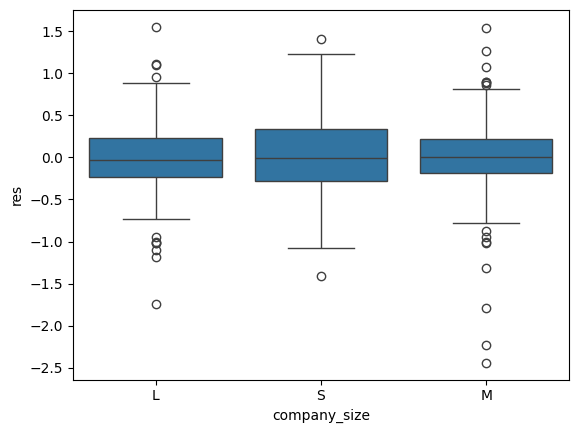

In [68]:
df2['res'] = reg2.resid

sns.boxplot(data=df2, x='company_size', y='res')

<Axes: xlabel='remote_ratio', ylabel='res'>

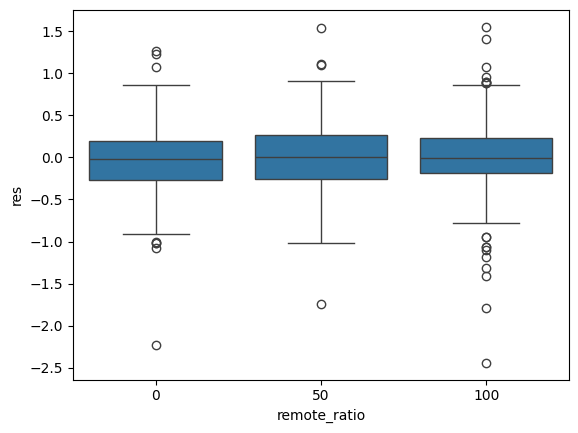

In [69]:
sns.boxplot(data=df2, x='remote_ratio', y='res')

<Axes: xlabel='experience_level', ylabel='res'>

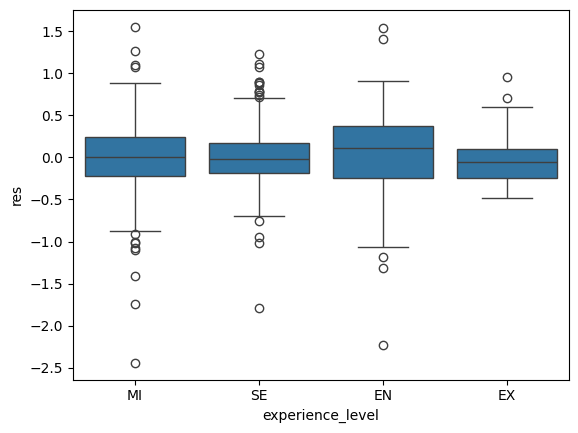

In [70]:
sns.boxplot(data=df2, x='experience_level', y='res')

<Axes: xlabel='work_year', ylabel='res'>

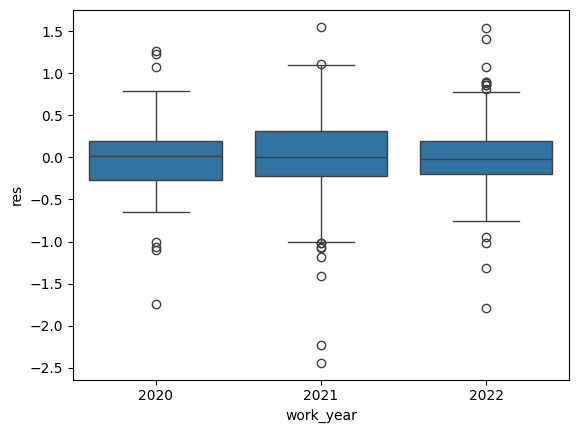

In [71]:
sns.boxplot(data=df2, x='work_year', y='res')

Analisamos o resíduo de algumas variáveis presentes no modelo, podemos verificar que a concentração dos resídos é em torno de zero, indicando que o modelo consegue fazer boas previsões sobre a variável alvo.

* Avaliando as suposições do modelo

O modelo de regressão parte de algumas suposições, para validar a eficácia do modelo, é necessário que estas suposições sejam satisfeitas:

<Axes: xlabel='res', ylabel='Count'>

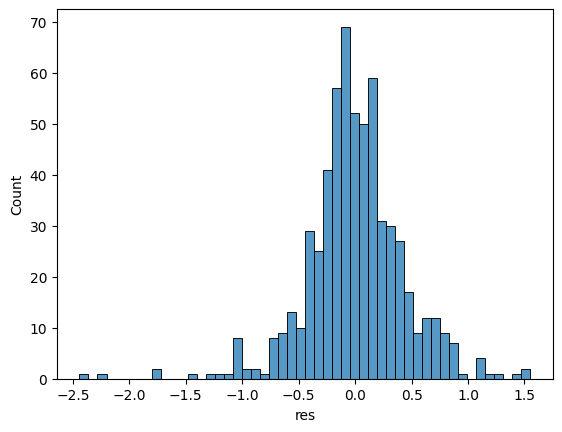

In [72]:
# Distribuição do resíduo:

sns.histplot(data=df2, x='res', bins=50)

A distribuição do resíduo é aproximadamente normal. Notamos novamente a presença de alguns resíduos abaixo de -2. A ocorrência destes resíduos podem estar associadas a outliers. Um opção é avaliarmos os pontos referentes a estes resíduos e podemos considerar até sua remoção.

c:\Users\Daniels\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:848: RuntimeWarning: divide by zero encountered in divide
  return self.resid / sigma / np.sqrt(1 - hii)


<Axes: ylabel='student_resid'>

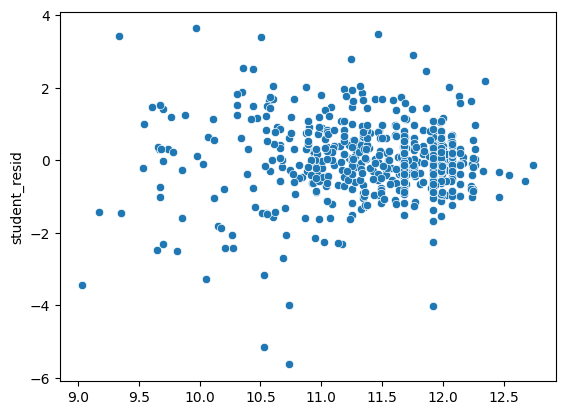

In [73]:
st_res = reg2.outlier_test()
sns.scatterplot(x = reg2.predict(), y= st_res.student_resid)

A concentração de pontos esta mais a direita, porém não detectamos um padrão de crescimento ou diminuição. Indicando que o resíduo é razoavelmente constante.

Identificamos acima a independência do resíduo em relação as variáveis. Com isso avaliamos as suposições do modelo de regressão.

In [74]:
# Avaliando os pontos com resíduo abaixo de -1.5:

df_aux = df2[df2['res'] < -1.5]

df_aux

,id,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,res
15,15,2020,MI,FT/CT,Data Analyst,8000,USD,8000,Not_US,50,Not_US,L,-1.745214
185,185,2021,MI,FT/CT,Data Engineer,4000,USD,4000,Not_US,100,Not_US,M,-2.441226
238,238,2021,EN,FT/CT,Data Scientist,4000,USD,4000,Not_US,0,Not_US,M,-2.233860
579,579,2022,SE,FT/CT,Data Engineer,25000,USD,25000,US,100,US,M,-1.788216


O salário indicado destes dados é muito abaixo da média, possivelmente houve um erro na digitação, logo vamos excluir os pontos.

In [75]:
df2 = df2.drop(df_aux.index, errors='ignore')

Treinando o modelo final:

In [76]:
reg_final = smf.ols(formula2, data=df2).fit()

print(f'r^2: {round(reg_final.rsquared,2)}')

r^2: 0.71


Obtemos um r^2 igual a 0.71, demonstrando que nosso modelo tem uma boa capacidade de explicar a variável alvo com base nas variáveis explicativas.

In [77]:
# Erros médios absolutos:

mae_log = mean_absolute_error(np.log(df2['salary_in_usd']), reg_final.predict(df2))
mae = mean_absolute_error(df2['salary_in_usd'], np.exp(reg_final.predict(df2)))

print(f'Erro médio absoluto do logarítmo do salário: {round(mae_log,3)}\n')
print(f'Erro médio absolutodo salário: {round(mae, 2)} Dólares')

Erro médio absoluto do logarítmo do salário: 0.299

Erro médio absolutodo salário: 29739.19 Dólares


Parâmetros e informações do modelo final:

In [78]:
reg_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(salary_in_usd)   R-squared:                       0.707
Model:                               OLS   Adj. R-squared:                  0.687
Method:                    Least Squares   F-statistic:                     34.83
Date:                   Tue, 07 May 2024   Prob (F-statistic):          1.96e-124
Time:                           21:25:56   Log-Likelihood:                -309.48
No. Observations:                    603   AIC:                             699.0
Df Residuals:                        563   BIC:                             875.0
Df Model:                             39                                         
Covariance Type:               nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           10.4886      0.359     29.214      0.000       9.783      11.194
C(work_year)[T.2021]                -0.0702      0.060     -1.177      0.240      -0.187       0.047
C(work_year)[T.2022]                -0.0339      0.065     -0.517      0.605      -0.162       0.095
C(experience_level)[T.EX]            0.9114      0.113      8.081      0.000       0.690       1.133
C(experience_level)[T.MI]            0.2798      0.058      4.830      0.000       0.166       0.394
C(experience_level)[T.SE]            0.5643      0.060      9.470      0.000       0.447       0.681
C(employment_type)[T.FT/CT]          0.6755      0.124      5.466      0.000       0.433       0.918
C(employee_residence)[T.US]          0.5563      0.094      5.894      0.000       0.371       0.742
C(salary_currency)[T.BRL]           -1.7583      0.431     -4.079      0.000      -2.605      -0.912
C(salary_currency)[T.CAD]           -0.2244      0.316     -0.710      0.478      -0.845       0.396
C(salary_currency)[T.CHF]            0.1699      0.515      0.330      0.741      -0.841       1.181
C(salary_currency)[T.CLP]           -0.9108      0.516     -1.765      0.078      -1.925       0.103
C(salary_currency)[T.CNY]           -0.8411      0.521     -1.616      0.107      -1.864       0.181
C(salary_currency)[T.DKK]           -0.1676      0.436     -0.384      0.701      -1.025       0.690
C(salary_currency)[T.EUR]           -0.4362      0.303     -1.441      0.150      -1.031       0.158
C(salary_currency)[T.GBP]           -0.1578      0.306     -0.516      0.606      -0.758       0.443
C(salary_currency)[T.HUF]           -0.9458      0.425     -2.225      0.027      -1.781      -0.111
C(salary_currency)[T.INR]           -1.4405      0.310     -4.642      0.000      -2.050      -0.831
C(salary_currency)[T.JPY]           -0.2640      0.389     -0.679      0.497      -1.027       0.499
C(salary_currency)[T.MXN]           -2.2535      0.427     -5.272      0.000      -3.093      -1.414
C(salary_currency)[T.PLN]           -1.0302      0.385     -2.679      0.008      -1.786      -0.275
C(salary_currency)[T.SGD]            0.1260      0.424      0.298      0.766      -0.706       0.958
C(salary_currency)[T.TRY]           -1.6308      0.389     -4.196      0.000      -2.394      -0.867
C(salary_currency)[T.USD]           -0.3694      0.306     -1.209      0.227      -0.970       0.231
C(company_location)[T.US]            0.1012      0.096      1.055      0.292      -0.087       0.289
C(company_size)[T.M]                -0.1289      0.047     -2.761      0.006      -0.221      -0.037
C(company_size)[T.S]                -0.2168      0.061     -3.560      0.000      -0.336      -0.097
C(job_title)[T.Archi

Com isso concluímos o projeto com a criação de um modelo com boa capacidade de explicar o salário com base nos dados presentes. Visualizamos as variáveis explicativas e suas relevâncias estatisticas para a previsão da variável alvo e com o modelo final podemos analisar métricas estatísticas relevantes e observar a influência de cada variável (e classe) para a variável alvo através de seus coeficientes.